<a href="https://colab.research.google.com/github/sofiammatias/tick-tick-bloom/blob/main/tick_tick_bloom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tick Tick Bloom Challenge (Driven Data)
The goal in this challenge is to use satellite imagery to detect and classify the severity of cyanobacteria blooms in small, inland water bodies. The resulting algorithm will help water quality managers better allocate resources for in situ sampling, and make more informed decisions around public health warnings for critical resources like drinking water reservoirs. Ultimately, more accurate and more timely detection of algal blooms helps keep both the human and marine life that rely on these water bodies safe and healthy.

## Imports

In [41]:
!pip install odc.stac
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [42]:
!pip install planetary_computer
!pip install pystac_client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [77]:
!pip install rioxarray

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 KB 2.2 MB/s eta 0:00:00


In [43]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
import cv2
import os
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline

In [45]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data: Collection and EDA

In [46]:
data_path = "/content/data/final/public"
DATA_DIR = Path.cwd().parent.resolve() / data_path
if not (DATA_DIR.exists()):
  os.makedirs(data_path)
metadata_file = '/content/drive/MyDrive/Colab Notebooks/tick-tick-bloom/metadata.csv'
metadata = pd.read_csv(metadata_file)

## Metadata.csv

### Location

In [47]:
display(metadata.head())
metadata.split.value_counts(dropna=False)

,uid,latitude,longitude,date,split
0,aabm,39.080319,-86.430867,2018-05-14,train
1,aabn,36.559700,-121.510000,2016-08-31,test
2,aacd,35.875083,-78.878434,2020-11-19,train
3,aaee,35.487000,-79.062133,2016-08-24,train
4,aaff,38.049471,-99.827001,2019-07-23,train


train    17060
test      6510
Name: split, dtype: int64

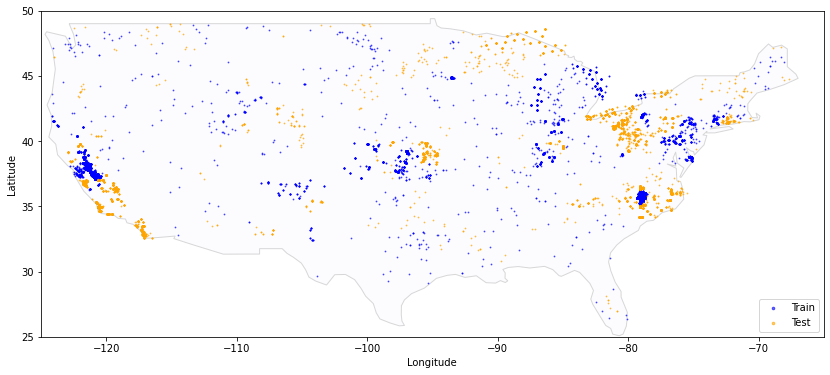

In [48]:
# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(15, 6))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

### Date

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


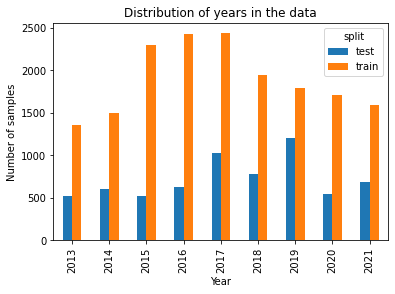

In [49]:
# convert date to pd.datetime
metadata.date = pd.to_datetime(metadata.date)

# what is the date range?
display (metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max)))

# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")
plt.show()

Seasons


summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

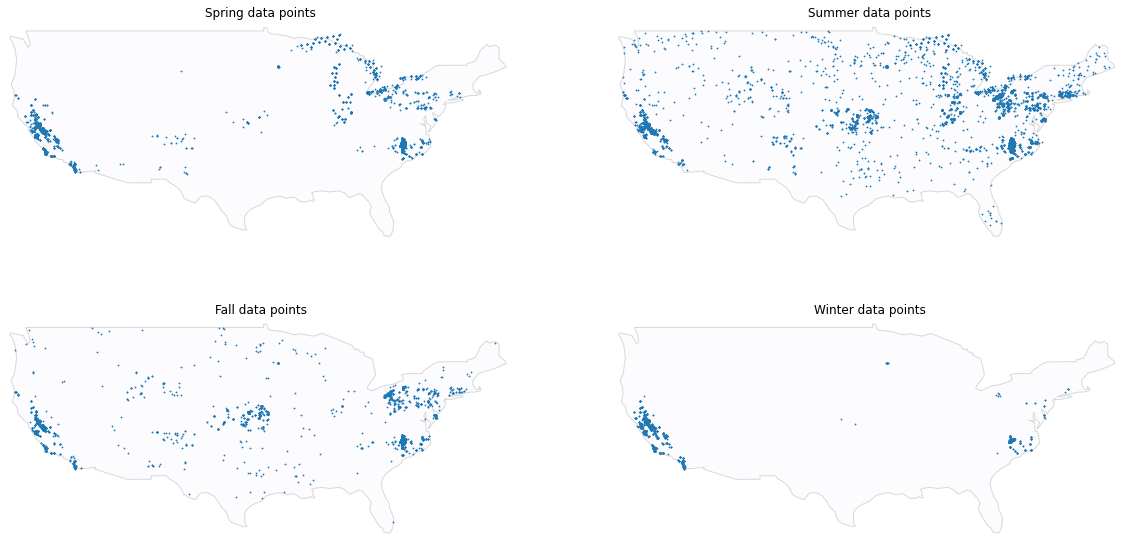

In [50]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
print ('Seasons')
display(metadata.season.value_counts())

# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

## Train Labels.csv

In [51]:
data_path = "/content/data/final/public"
DATA_DIR = Path.cwd().parent.resolve() / data_path
if not (DATA_DIR.exists()):
  os.makedirs(data_path)
train_labels_file = '/content/drive/MyDrive/Colab Notebooks/tick-tick-bloom/train_labels.csv'
train_labels = pd.read_csv(train_labels_file)

In [52]:
display(train_labels.head())
train_labels.shape

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


(17060, 4)

In [53]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)
train_labels_and_metadata

,uid,region,severity,density,latitude,longitude,date,split,season
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,spring
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,fall
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,summer
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,summer
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,summer
...,...,...,...,...,...,...,...,...,...
17055,zzsv,south,3,113125.0,38.707825,-75.080867,2018-06-27,train,summer
17056,zzuq,south,3,175726.0,35.794000,-79.015368,2015-08-06,train,summer
17057,zzwo,midwest,2,48510.0,39.792190,-99.971050,2017-06-19,train,summer
17058,zzwq,south,1,1271.0,35.794000,-79.012551,2015-03-24,train,spring


Text(0.5, 1.0, 'Train labels severity level counts')

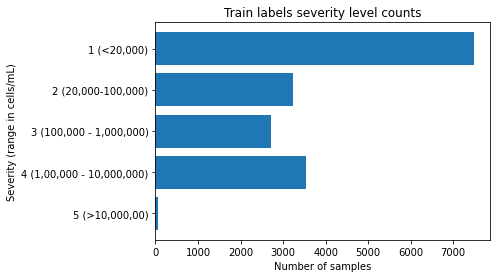

In [54]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

In [55]:
train_labels.density.describe()

count    1.706000e+04
mean     1.074537e+06
std      6.836693e+06
min      0.000000e+00
25%      4.066000e+03
50%      3.270975e+04
75%      4.849192e+05
max      8.046675e+08
Name: density, dtype: float64

# Process Feature Data

Feature data is not provided directly. Instead, access to all feature data can only be done through **external, publicly available APIs**. Relevant imagery can be identified using the location and date of each sample, listed in metadata.csv.

Pull in matching satellite imagery will be done using Microsoft's Planetary Computer. Use only **Sentinel-2 L2A** and **Landsat Level-2** satellite imagery. Sentinel-2 L1C and Landsat Level-1 imagery are also allowed.

In [56]:
# Establish a connection to the STAC API

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [58]:
import geopy.distance as distance
import rioxarray
from IPython.display import Image
from PIL import Image as PILImage
import planetary_computer as pc
from pystac_client import Client

##Location range: 
search an area with 50,000 meters on either side of our sample point (100,000 m x 100,000 m), to make sure we're pulling in all relevant imagery. This is just a starting point, and you can improve on how to best search for the correct location in the Planetary Computer.

##Time range: 
We want our feature data to be as close to the time of the sample as possible, because in algal blooms in small water bodies form and move very rapidly. Remember, you cannot use any data collected after the date of the sample.

Imagery taken with roughly 10 days of the sample will generally still be an accurate representation of environmental conditions at the time of the sample. For some data points you may not be able to get data within 10 days, and may have to use earlier data. We'll search the fifteen days up to the sample time, including the sample date.

##Select one image
The planetary computer returned 46 different items! Let's look at some of the details of the items that were found to match our label.

To keep things simple, we'll just choose one image to input into our model. Keep in mind that it is possible to incorporate multiple images!

We'll narrow to one image in two steps:

- If any Sentinel imagery is available, filter to only Sentinel imagery. Sentinel-2 is higher resolution than Landsat, which is extremely helpful for blooms in small water bodies. In this case, two images are from Sentinel and contain the actual sample location.
- Select the item that is the closest time wise to the sampling date. This gives us a Sentinel-2A item that was captured on 10/20/2022 - two days before our sample was collected on 10/22.

This is a very simple way to choose the best image. 

#Functions to sort and get imagery

Be aware that querying the Planetary Computer for all of the images is going to take a LONG time! You'll want to find ways to both save work as you go, and optimize your code for efficiency.

We'll save out the processed features for each image as we go, to make sure we only have to run time-intensive parts of our code once.

For time, here we'll train on a randomly selected small subset of the training data. The cell below is highly time intensive, because for each row in the data we have to query the planetary computer catalog and process imagery.

We'll still include and predict on all of the test data.

In [88]:
def select_best_item(items, date, latitude, longitude):
    """
    Select the best satellite item given a sample's date, latitude, and longitude.
    If any Sentinel-2 imagery is available, returns the closest sentinel-2 image by
    time. Otherwise, returns the closest Landsat imagery.

    Returns a tuple of (STAC item, item platform name, item date)
    """
    # get item details
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "item_obj": item,
            }
            for item in items
        ]
    )

    # filter to items that contain the point location, or return None if none contain the point
    item_details["contains_sample_point"] = (
        (item_details.min_lat < latitude)
        & (item_details.max_lat > latitude)
        & (item_details.min_long < longitude)
        & (item_details.max_long > longitude)
    )
    item_details = item_details[item_details["contains_sample_point"] == True]
    if len(item_details) == 0:
        return (np.nan, np.nan, np.nan)

    # add time difference between each item and the sample
    item_details["time_diff"] = pd.to_datetime(date) - pd.to_datetime(
        item_details["datetime"]
    )

    # if we have sentinel-2, filter to sentinel-2 images only
    item_details["sentinel"] = item_details.platform.str.lower().str.contains(
        "sentinel"
    )
    if item_details["sentinel"].any():
        item_details = item_details[item_details["sentinel"] == True]

    # return the closest imagery by time
    best_item = item_details.sort_values(by="time_diff", ascending=True).iloc[0]

    return (best_item["item_obj"], best_item["platform"], best_item["datetime"])


def image_to_features(image_array):
    """
    Convert an image array of the form (color band, height, width) to a
    1-dimensional list of features. Returns a list where the first three
    values are the averages of each color band, and the second three
    values are the medians of each color band.
    """
    averages = image_array.mean(axis=(1, 2)).tolist()
    medians = np.median(image_array, axis=(1, 2)).tolist()

    return averages + medians

In [ ]:
BENCHMARK_DATA_DIR = DATA_DIR.parents[1] / "benchmark"

# save image arrays in case we want to generate more features
IMAGE_ARRAY_DIR = BENCHMARK_DATA_DIR / "image_arrays"
IMAGE_ARRAY_DIR.mkdir(exist_ok=True, parents=True)
# take a random subset of the training data for the benchmark
train_subset = metadata[metadata["split"] == "train"].sample(n=2500, random_state=2)

# combine train subset with all test data
metadata_subset = pd.concat([train_subset, metadata[metadata["split"] == "test"]])
metadata_subset.split.value_counts(dropna=False)

In [ ]:
# this cell takes a LONG time because it iterates over all data!

# save outputs in dictionaries
selected_items = {}
features_dict = {}
errored_ids = []


for row in tqdm(metadata_subset.itertuples(), total=len(metadata_subset)):
    pass
    # check if we've already saved the selected image array
    image_array_pth = IMAGE_ARRAY_DIR / f"{row.uid}.npy"

    if image_array_pth.exists():
        with open(image_array_pth, "rb") as f:
            image_array = np.load(f)

        # convert image to 1-dimensional features
        image_features = image_to_features(image_array)
        features_dict[row.uid] = image_features

    # search and load the image array if not
    else:
        try:
            ## QUERY STAC API
            # get query ranges for location and date
            search_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=50000
            )
            date_range = get_date_range(row.date, time_buffer_days=15)

            # search the planetary computer
            search = catalog.search(
                collections=["sentinel-2-l2a", "landsat-c2-l2"],
                bbox=search_bbox,
                datetime=date_range,
            )
            items = [item for item in search.get_all_items()]

            ## GET BEST IMAGE
            if len(items) == 0:
                pass
            else:
                best_item, item_platform, item_date = select_best_item(
                    items, row.date, row.latitude, row.longitude
                )
                # add to dictionary tracking best items
                selected_items[row.uid] = {
                    "item_object": best_item,
                    "item_platform": item_platform,
                    "item_date": item_date,
                }

            ## CONVERT TO FEATURES
            # get small bbox just for features
            feature_bbox = get_bounding_box(
                row.latitude, row.longitude, meter_buffer=100
            )

            # crop the image
            if "sentinel" in item_platform.lower():
                image_array = crop_sentinel_image(best_item, feature_bbox)
            else:
                image_array = crop_landsat_image(best_item, feature_bbox)

            # save image array so we don't have to rerun
            with open(image_array_pth, "wb") as f:
                np.save(f, image_array)

            # convert image to 1-dimensional features
            image_features = image_to_features(image_array)
            features_dict[row.uid] = image_features

        # keep track of any that ran into errors without interrupting the process
        except:
            errored_ids.append(row.uid)